In [2]:
##################Compute the pearson correlation between 2 time series and track the latency -------------------------------

################## Additonally, collect real-time data on the coronavirus cases and pre-processing work -----------------------


import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import plotly
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)

In [4]:
#collect the real-time coronavirus data: confirmed, deaths, recovered
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [5]:
#collect the nasdaq historical data ---- TO UPDATE with last data

data_NSDQ = pd.read_csv('C:/Users/Eytan/Documents/Stock Predicition/^IXIC.csv',header=0)

#transfor the data into datetime
data_NSDQ['Date'] = pd.to_datetime(data_NSDQ['Date'],format='%Y-%m-%d')

#select only the corona period
data_NSDQ = data_NSDQ[data_NSDQ['Date'].isin(pd.date_range('2020-01-20', '2020-04-06'))]

#collect the deaths,confirmed,recovered of coronavirus in US
deaths_US = deaths[deaths['Country/Region']=='US']
deaths_US = deaths_US.drop(['Province/State','Lat','Long'],axis=1)

confirmed_US= confirmed[confirmed['Country/Region']=='US']
confirmed_US = confirmed_US.drop(['Province/State','Lat','Long'],axis=1)

recovered_US = recovered[recovered['Country/Region']=='US']
recovered_US = recovered_US.drop(['Province/State','Lat','Long'],axis=1)

confirmed_US = confirmed_US.sum()
confirmed_US = confirmed_US[2:len(confirmed_US)]
confirmed_US = pd.DataFrame(confirmed_US,columns=['confirmed'])

recovered_US = recovered_US.sum()
recovered_US = recovered_US[2:len(recovered_US)]
recovered_US = pd.DataFrame(recovered_US,columns=['recovered'])

deaths_US = deaths_US.sum()
deaths_US = deaths_US[2:len(deaths_US)]
deaths_US = pd.DataFrame(deaths_US,columns=['deaths'])

deaths_US.index = pd.to_datetime(deaths_US.index)
confirmed_US.index = pd.to_datetime(confirmed_US.index)

In [6]:
#compute the daily additional deaths and create a new column
deaths_US['new'] = deaths_US['deaths'].diff()
deaths_US = deaths_US[['new']]

In [7]:
#pre-processing on the Nasdaq data and merge with  the new deaths in  US
data_NSDQ = data_NSDQ[['Date','Adj Close']]
data_NSDQ.index = data_NSDQ['Date']
data_NSDQ = data_NSDQ[['Adj Close']]
merge_US = data_NSDQ.merge(deaths_US,left_index=True, right_index=True)

from sklearn import preprocessing
import scipy.stats as stats
min_max_scaler = preprocessing.MinMaxScaler()

#scale the data
merge_US['Adj Close'] = min_max_scaler.fit_transform(merge_US[['Adj Close']].values)
merge_US['new'] = min_max_scaler.fit_transform(merge_US[['new']].values)

#plot with plotly
merge_US.iplot()

In [8]:
#compute the pearson correlation

merge_US_overall_pearson_r = merge_US.corr().iloc[0,1]
print(f"The Pearson r is: {merge_US_overall_pearson_r}")

The Pearson r is: -0.446277252034767


In [9]:
#check the correlation between two stocks from the same company listed in two different exchanges - example Sanofi --- objective is to find the latency between two time-series highly correlatied -- potential arbitrage from one market to another


data_SAN = pd.read_csv('C:/Users/Eytan/Documents/Stock Predicition/SAN.PA.csv',header=0)
data_SNY = pd.read_csv('C:/Users/Eytan/Documents/Stock Predicition/SNY.csv',header=0)
data_SAN['Date'] = pd.to_datetime(data_SAN['Date'],format='%Y-%m-%d')
data_SNY['Date'] = pd.to_datetime(data_SNY['Date'],format='%Y-%m-%d')

#not mandartory: filter on the coronavirus starting date -- just for reference
data_SAN = data_SAN[data_SAN['Date'].isin(pd.date_range('2020-01-01', '2020-04-03'))]
data_SNY = data_SNY[data_SNY['Date'].isin(pd.date_range('2020-01-01', '2020-04-03'))]

data_SAN = data_SAN[['Date','Adj Close']]
data_SNY = data_SNY[['Date','Adj Close']]

data_SAN.index = data_SAN['Date']
data_SNY.index = data_SNY['Date']

data_SAN = data_SAN[['Adj Close']]
data_SNY = data_SNY[['Adj Close']]


merge_sanofi = data_SAN.merge(data_SNY,left_index=True, right_index=True)

merge_sanofi['Adj Close_x'] = min_max_scaler.fit_transform(merge_sanofi[['Adj Close_x']].values)
merge_sanofi['Adj Close_y'] = min_max_scaler.fit_transform(merge_sanofi[['Adj Close_y']].values)
merge_sanofi.iplot()

In [10]:
merge_sanofi_overall_pearson_r = merge_sanofi.corr().iloc[0,1]
print(f"The Pearson correlation r is: {merge_sanofi_overall_pearson_r}")

The Pearson correlation r is: 0.9696037626990334


C:\Users\Eytan\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Eytan\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning:

divide by zero encountered in true_divide



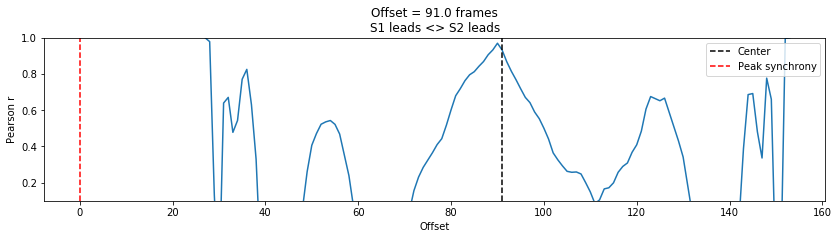

In [11]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = merge_sanofi['Adj Close_x']
d2 = merge_sanofi['Adj Close_y']

#parameters to adjust
seconds = 3
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,1], xlabel='Offset',ylabel='Pearson r')
#ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
#ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()